In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

### Formatting functions and variables

In [51]:
# Degree symbol to be use in print statements
degree_sign= u'\N{DEGREE SIGN}'

#Align text to the left
def left_align(df):
    left_aligned_df = df.style.set_properties(**{'text-align': 'left'}).set_table_styles(
        [ dict(selector='th', props=[('text-align', 'left')] ) ])
    
    return left_aligned_df

## Temperature Analysis II

In [20]:
# User function take star and and date in the format 'YYYYMMDD' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start, end):
    
    try:
        start_date = datetime.strptime(start, '%Y%m%d')
        end_date = datetime.strptime(end, '%Y%m%d')
    except:
        return (f"This is the incorrect date format. It should be YYYYMMDD<br/>")
    
    start_date = start_date - dt.timedelta(days=365)
    end_date = end_date - dt.timedelta(days=365)
    
    session = Session(engine)
    temp_results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs),\
                                 func.max(Measurement.tobs)).filter(Measurement.date.between(start_date, end_date)).all()
    session.close()

    return temp_results

In [25]:
# Calculate the tmin, tavg, and tmax with calc_temps function
temp_results = calc_temps('20151010', '20151110')
for tmin, tavg, tmax in temp_results:
    print(f"The Min Temperature for the selected date range is {round(tmin, 1)}{degree_sign}F")
    print(f"The Avg Temperature for the selected date range is {round(tavg, 1)}{degree_sign}F")
    print(f"The Max Temperature for the selected date range is {round(tmax, 1)}{degree_sign}F")

The Min Temperature for the selected date range is 63.0°F
The Avg Temperature for the selected date range is 76.0°F
The Max Temperature for the selected date range is 84.0°F


(0.0, 106.01834862385321)

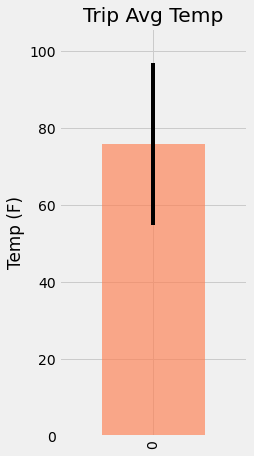

In [12]:
# Bar Plot with y error bar from the temp_results query
for tmin, tavg, tmax in temp_results:
        temp_dict = {}
        temp_dict['tmin'] = tmin
        temp_dict['tavg'] = tavg
        temp_dict['tmax'] = tmax

temp_info = pd.DataFrame(temp_dict, index=[0]) 
yerr= [temp_info['tmax'] - temp_info['tmin']]

temp_info['tavg'].plot.bar(yerr=yerr, width=0.6, alpha = 0.65, color='coral', figsize=(3, 7))
plt.title('Trip Avg Temp')
plt.ylabel('Temp (F)')
plt.ylim(0, temp_info['tavg'].values+30)

### Daily Rainfall Average

In [56]:
session = Session(engine)
r_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
r_date = datetime.strptime(r_date[0], '%Y-%m-%d')
r_date

datetime.datetime(2017, 8, 23, 0, 0)

In [52]:
# Query the total amount of rainfall (precipitation) per weather station for trip dates using the previous year's 
# matching dates.

# Trip dates
trip_start = '2017-04-11'
trip_end = '2017-04-18'

# Format dates and substract a year to be used for historical data
trip_start = datetime.strptime(trip_start, '%Y-%m-%d') - dt.timedelta(days=365)
trip_end = datetime.strptime(trip_end, '%Y-%m-%d') - dt.timedelta(days=365)

session = Session(engine)

# Query total amount of rainfall per
rainfall = session.query(Measurement.station, Station.name, func.sum(Measurement.prcp), Measurement.date, Station.latitude, \
                         Station.longitude, Station.elevation).filter(Measurement.station == Station.station). \
                         filter(Measurement.date >= trip_start).filter(Measurement.date <= trip_end). \
                         order_by(desc(func.sum(Measurement.prcp))).group_by(Measurement.station).all()

# Create DataFrame
rainfall_list = []
for station, name, prcp, date, lat, lng, elevation in rainfall:
    rainfall_dict = {}
    rainfall_dict['station'] = station
    rainfall_dict['name'] = name
    rainfall_dict['total_prcp'] = prcp
    rainfall_dict['date'] = date
    rainfall_dict['latitude'] = lat
    rainfall_dict['longitude'] = lng
    rainfall_dict['elevation'] = elevation
    rainfall_list.append(rainfall_dict)
rainfall_df = pd.DataFrame(rainfall_list)

left_align(rainfall_df)

,station,name,total_prcp,date,latitude,longitude,elevation
0,USC00516128,"MANOA LYON ARBO 785.2, HI US",8.260000,2016-04-12,21.333100,-157.802500,152.400000
1,USC00519281,"WAIHEE 837.5, HI US",1.420000,2016-04-12,21.451670,-157.848890,32.900000
2,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",0.850000,2016-04-12,21.335560,-157.711390,19.500000
3,USC00513117,"KANEOHE 838.1, HI US",0.740000,2016-04-12,21.423400,-157.801500,14.600000
4,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",0.540000,2016-04-12,21.521300,-157.837400,7.000000
5,USC00519397,"WAIKIKI 717.2, HI US",0.330000,2016-04-12,21.271600,-157.816800,3.000000
6,USC00517948,"PEARL CITY, HI US",nan,2016-04-18,21.393400,-157.975100,11.900000


In [54]:
# Create function to calculate the daily normals 
def daily_normals(start, end):

    try:
        # Format dates and strip year
        start_date = datetime.strptime(start, '%Y-%m-%d').strftime("%m-%d")
        end_date = datetime.strptime(end, '%Y-%m-%d').strftime("%m-%d")

    except:
        return (f"This is the incorrect date format. It should be YYYY-MM-DD<br/>")
    
    session = Session(engine)    
    
    # Query
    daily_normals = session.query(Measurement.date, func.min(Measurement.tobs), func.avg(Measurement.tobs), \
                                  func.max(Measurement.tobs)).filter(func.strftime("%m-%d", Measurement.date) >= start_date).filter(func.strftime("%m-%d", Measurement.date) <= end_date).group_by(func.strftime("%m-%d", Measurement.date)).all()

    session.close()
    
    # Create DataFrame with query results
    normals_list = []
    for date, tmin, tavg, tmax in daily_normals:
        normals_dict = {}
        normals_dict['date'] = date
        normals_dict['tmin'] = tmin
        normals_dict['tavg'] = tavg
        normals_dict['tmax'] = tmax
        normals_list.append(normals_dict)

    normals_df = pd.DataFrame(normals_list)
    
    return normals_df

In [53]:
# Calculate the daily normals using the daily_normals function

# Start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Query
normals_df = daily_normals(start_date, end_date)

# Set date column as index
normals_df.set_index('date', inplace =True)

# Left aligned DataFrame
left_align(normals_df)

,tmin,tavg,tmax
date,,,
2014-08-01,67.000000,75.540000,83.000000
2015-08-02,68.000000,75.603774,84.000000
2015-08-03,70.000000,76.611111,85.000000
2015-08-04,69.000000,76.711538,84.000000
2015-08-05,69.000000,76.148148,82.000000
2017-08-06,67.000000,76.250000,83.000000
2016-08-07,71.000000,77.156863,83.000000


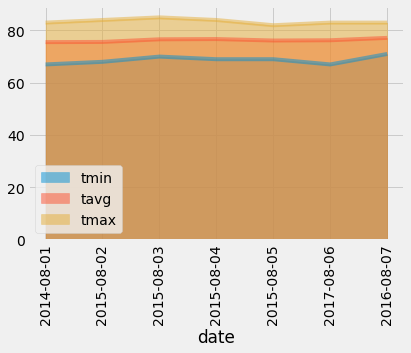

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot(kind='area', stacked=False, rot=90)

## Close Session

In [ ]:
session.close()